# Problem Statement

# Inspect and Understand the Data

In [240]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from datetime import date
import plotly.graph_objs as go
!pip install --upgrade pip
!pip install prophet
from prophet import Prophet

import warnings
warnings.filterwarnings('ignore') 

In [241]:
data2 = pd.read_csv('Sales.csv')

In [242]:
data1 = pd.read_csv('Products.csv')

In [243]:
data3 = pd.read_csv('Customers.csv', encoding='latin1')

In [244]:
data_12 = pd.merge(data1, data2, on='ProductKey', suffixes=('_left', '_right'))
data = pd.merge(data_12, data3, on='CustomerKey', suffixes=('_left', '_right')).drop(['Delivery Date'], axis=1) #49719 missing value in Delivery date columns

# Preparation

In [245]:
# drop missing value
data.dropna(inplace=True)

In [246]:
#remove duplicate value
data = data.drop_duplicates()

In [247]:
# Order Date and Birthday columns to datetime
data['Order Date'] = pd.to_datetime(data['Order Date'], format='%m/%d/%Y', errors='coerce')
data['Birthday'] = pd.to_datetime(data['Birthday'], format='%m/%d/%Y', errors='coerce')

In [248]:
# Create 'Order Month' and 'Order Year' column
data['Order Month'] = data['Order Date'].dt.month
data['Order Year'] = data['Order Date'].dt.year

In [249]:
data.head()

,ProductKey,Product Name,Brand,Color,Unit Cost USD,Unit Price USD,SubcategoryKey,Subcategory,CategoryKey,Category,...,Name,City,State Code,State,Zip Code,Country,Continent,Birthday,Order Month,Order Year
0,1,Contoso 512MB MP3 Player E51 Silver,Contoso,Silver,$6.62,$12.99,101,MP4&MP3,1,Audio,...,Christina Neustadt,Schauren,RP,Rheinland-Pfalz,55758,Germany,Europe,1982-11-27,5,2016
1,82,NT Wireless Bluetooth Stereo Headphones E302 Pink,Northwind Traders,Pink,$18.65,$40.55,106,Bluetooth Headphones,1,Audio,...,Christina Neustadt,Schauren,RP,Rheinland-Pfalz,55758,Germany,Europe,1982-11-27,12,2017
2,1379,Contoso Lifestyles Series - Big Button Cordles...,Contoso,White,$10.58,$23.00,501,Home & Office Phones,5,Cell phones,...,Christina Neustadt,Schauren,RP,Rheinland-Pfalz,55758,Germany,Europe,1982-11-27,10,2019
3,1407,Contoso Phone with Memory Dialing-2 lines E90 ...,Contoso,Grey,$8.16,$16.00,501,Home & Office Phones,5,Cell phones,...,Christina Neustadt,Schauren,RP,Rheinland-Pfalz,55758,Germany,Europe,1982-11-27,12,2017
4,1594,SV DVD 38 DVD Storage Binder E25 Red,Southridge Video,Red,$5.09,$9.99,602,Movie DVD,6,"Music, Movies and Audio Books",...,Christina Neustadt,Schauren,RP,Rheinland-Pfalz,55758,Germany,Europe,1982-11-27,5,2016


In [250]:
#create a column for customer age
data['Customer Age'] = pd.to_datetime(data['Birthday']) - pd.to_datetime('today')
data['Customer Age'] = round(abs(data['Customer Age'].dt.days / 365.25), 1)

In [251]:
data.head()

,ProductKey,Product Name,Brand,Color,Unit Cost USD,Unit Price USD,SubcategoryKey,Subcategory,CategoryKey,Category,...,City,State Code,State,Zip Code,Country,Continent,Birthday,Order Month,Order Year,Customer Age
0,1,Contoso 512MB MP3 Player E51 Silver,Contoso,Silver,$6.62,$12.99,101,MP4&MP3,1,Audio,...,Schauren,RP,Rheinland-Pfalz,55758,Germany,Europe,1982-11-27,5,2016,41.6
1,82,NT Wireless Bluetooth Stereo Headphones E302 Pink,Northwind Traders,Pink,$18.65,$40.55,106,Bluetooth Headphones,1,Audio,...,Schauren,RP,Rheinland-Pfalz,55758,Germany,Europe,1982-11-27,12,2017,41.6
2,1379,Contoso Lifestyles Series - Big Button Cordles...,Contoso,White,$10.58,$23.00,501,Home & Office Phones,5,Cell phones,...,Schauren,RP,Rheinland-Pfalz,55758,Germany,Europe,1982-11-27,10,2019,41.6
3,1407,Contoso Phone with Memory Dialing-2 lines E90 ...,Contoso,Grey,$8.16,$16.00,501,Home & Office Phones,5,Cell phones,...,Schauren,RP,Rheinland-Pfalz,55758,Germany,Europe,1982-11-27,12,2017,41.6
4,1594,SV DVD 38 DVD Storage Binder E25 Red,Southridge Video,Red,$5.09,$9.99,602,Movie DVD,6,"Music, Movies and Audio Books",...,Schauren,RP,Rheinland-Pfalz,55758,Germany,Europe,1982-11-27,5,2016,41.6


In [252]:
# unit cost and unit price -> int
data['Unit Price USD Int'] = data['Unit Price USD'].str.replace(',', '').str[1:].astype(float)
data['Unit Cost USD Int'] = data['Unit Cost USD'].str.replace(',', '').str[1:].astype(float)

In [253]:
# create revenue columns
data['Revenue'] = data['Quantity'] * data['Unit Price USD Int']

In [254]:
# create Sales columns
data['Sales'] = data['Quantity'] * data['Unit Price USD Int']

In [255]:
# create a new column for Total Cost
data['Total Cost'] = data['Quantity'] * data['Unit Cost USD Int']

In [256]:
# create a new column for Profit
data['Profit'] = data['Revenue'] - data['Total Cost']

In [257]:
data.head(2)

,ProductKey,Product Name,Brand,Color,Unit Cost USD,Unit Price USD,SubcategoryKey,Subcategory,CategoryKey,Category,...,Birthday,Order Month,Order Year,Customer Age,Unit Price USD Int,Unit Cost USD Int,Revenue,Sales,Total Cost,Profit
0,1,Contoso 512MB MP3 Player E51 Silver,Contoso,Silver,$6.62,$12.99,101,MP4&MP3,1,Audio,...,1982-11-27,5,2016,41.6,12.99,6.62,12.99,12.99,6.62,6.37
1,82,NT Wireless Bluetooth Stereo Headphones E302 Pink,Northwind Traders,Pink,$18.65,$40.55,106,Bluetooth Headphones,1,Audio,...,1982-11-27,12,2017,41.6,40.55,18.65,243.30,243.30,111.90,131.40


In [258]:
# create a new column for Order Value Distribution
data['Order Value Distribution'] = (data['Revenue'] / data.groupby('Order Number')['Revenue'].transform('sum')) * 100

In [259]:
# create a new column for Average Order Value (AOV)
data['Average Order Value'] = data.groupby('Order Number')['Revenue'].transform('sum') / data.groupby('Order Number')['Revenue'].transform('count')

In [260]:
# create a new column for Customer Average Order Value (CAOV)
data['Customer Average Order Value'] = data.groupby('CustomerKey')['Revenue'].transform('sum') / data.groupby('CustomerKey')['Revenue'].transform('count')

# Statistics Descriptive

In [261]:
desc_stat = data.select_dtypes(include=['number'])
desc = pd.DataFrame()
desc['Total Sample'] = desc_stat.count()
desc['null'] = desc_stat.isnull().sum()
desc['nunique'] = desc_stat.nunique()
desc['unique'] = desc_stat.nunique() / desc_stat.shape[0] * 100
desc = desc.join(desc_stat.describe().T.drop(columns='count') )
desc

,Total Sample,null,nunique,unique,mean,std,min,25%,50%,75%,max
ProductKey,62854,0,2492,3.964744,1.125850e+03,709.235066,1.000000,4.370000e+02,1.358000e+03,1.650000e+03,2517.00
SubcategoryKey,62854,0,32,0.050912,4.502111e+02,212.722165,101.000000,3.030000e+02,5.010000e+02,6.020000e+02,808.00
CategoryKey,62854,0,8,0.012728,4.469739e+00,2.132800,1.000000,3.000000e+00,5.000000e+00,6.000000e+00,8.00
Order Number,62854,0,26313,41.863684,1.431105e+06,453157.949565,366000.000000,1.122001e+06,1.498017e+06,1.788012e+06,2243032.00
Line Item,62854,0,7,0.011137,2.164349e+00,1.365332,1.000000,1.000000e+00,2.000000e+00,3.000000e+00,7.00
CustomerKey,62854,0,11878,18.897763,1.181000e+06,586029.974034,301.000000,6.803065e+05,1.261460e+06,1.686629e+06,2099937.00
StoreKey,62854,0,58,0.092277,3.180445e+01,22.982885,0.000000,8.000000e+00,3.700000e+01,5.300000e+01,66.00
Quantity,62854,0,10,0.015910,3.144923e+00,2.256495,1.000000,1.000000e+00,2.000000e+00,4.000000e+00,10.00
Order Month,62854,0,12,0.019092,6.633579e+00,3.835018,1.000000,2.000000e+00,7.000000e+00,1.000000e+01,12.00
Order Year,62854,0,6,0.009546,2.018407e+03,1.272184,2016.000000,2.018000e+03,2.019000e+03,2.019000e+03,2021.00


# Business Questions 


What is the average revenue generated by each gender?

In [262]:
revenue_by_gender = data.groupby('Gender')['Revenue'].mean()
fig = px.bar(revenue_by_gender, title='Average Revenue by Gender')
fig.show()
#We can see that men contribute slightly more to revenue generation than women. 

Which state has the highest total sales?

In [263]:
sales_by_state = data.groupby('State')['Sales'].sum().sort_values(ascending=False).reset_index()

# Identify the highest and least values
max_value = sales_by_state['Sales'].max()
min_value = sales_by_state['Sales'].min()

# Create a text column for displaying only the highest and least values
sales_by_state['Text'] = sales_by_state['Sales'].apply(
    lambda x: f'{x:.2f}' if x == max_value or x == min_value else ''
)

# Create bar chart with conditional text labels
fig = px.bar(sales_by_state, x='State', y='Sales', title='Total Sales by State', log_y=True, text='Text')

# Update the layout to show text labels
fig.update_traces(textposition='outside')

# Adjust the layout for better visibility
fig.update_layout(
    uniformtext_minsize=8,
    uniformtext_mode='show',
    yaxis=dict(title='Sales', showgrid=True, zeroline=True),
    xaxis=dict(title='State')
)

# Show the figure
fig.show()





We can see that the state with the lowest sales is Mayotte, with sales amounting to 28.95, while the state with the highest sales is Gwynedd, with sales totaling 92.56412K.

What is the average age of customers in each continent?

In [264]:
age_by_continent = data.groupby('Continent')['Customer Age'].mean()
fig = px.bar(age_by_continent, title='Average Age by Continent')
fig.show()
#Here we can see that the average customer age of all these three Continents is around 55

What is the total profit generated in each country?

In [265]:
# Group by country and sum profits
profit_by_country = data.groupby('Country')['Profit'].sum().sort_values(ascending=False).reset_index()

# Create bar chart with value labels
fig = px.bar(profit_by_country, x='Country', y='Profit', title='Total Profit by Country', text='Profit')

# Update the layout to show text labels
fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')

# Adjust the layout for better visibility
fig.update_layout(
    uniformtext_minsize=8,
    uniformtext_mode='show',
    yaxis=dict(title='Profit', showgrid=True, zeroline=True),
    xaxis=dict(title='Country')
)

# Show the figure
fig.show()

We can see that the most profitable country is the United States, with a profit of 17 million, while the least profitable country is France, with a profit of 890 thousand

Reccomendation - To increase sales in other countries, the retailer could:

Market Research: Conduct thorough market research to understand local consumer preferences and behaviors.

Localization: Tailor product offerings, marketing campaigns, and pricing strategies to fit each country's unique cultural and economic context.

E-commerce Expansion: Invest in robust e-commerce platforms and logistics to reach more customers and facilitate easier transactions.

Partnerships: Form strategic partnerships with local businesses or influencers to enhance brand visibility and credibility.

Customer Engagement: Implement customer feedback loops and engage actively on social media to build relationships and trust.

Promotions and Discounts: Offer localized promotions and discounts to attract new customers and encourage repeat purchases.

Top 10 product by quantity

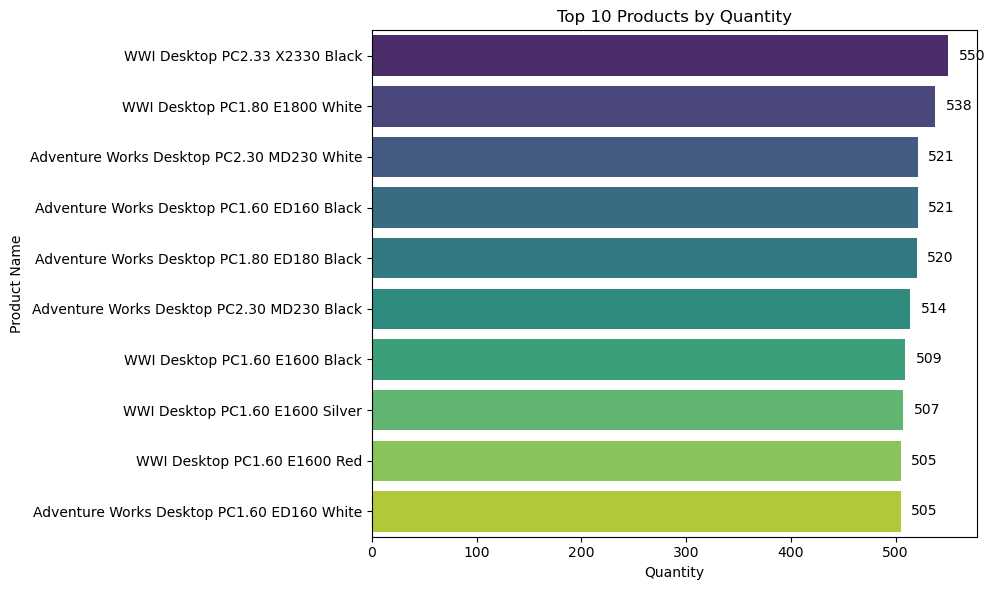

In [266]:
product_quantity = data.groupby('Product Name')['Quantity'].sum()
top_product = product_quantity.sort_values(ascending=False)

# Filter top 10 products by quantity
top_10 = top_product[top_product > 500].head(10)

# Create bar plot using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x=top_10.values, y=top_10.index, palette='viridis')

# Annotate each bar with its quantity value
for index, value in enumerate(top_10.values):
    plt.text(value + 10, index, f'{value}', va='center')

plt.title('Top 10 Products by Quantity')
plt.xlabel('Quantity')
plt.ylabel('Product Name')
plt.tight_layout()

# Show the plot
plt.show()

Here we can see that the top-selling item is the WWI Desktop PC2.33 X2330 Black, with a quantity sold of 550 units

How many times do people place an order by country? and 
what is the average price and cost of the items they buy?

In [267]:
data.groupby(['Country', 'Continent']).agg({'Order Number':'count','Unit Price USD Int': 'mean', 'Unit Cost USD Int': 'mean' }).sort_values(by='Order Number', ascending=False)

,,Order Number,Unit Price USD Int,Unit Cost USD Int
Country,Continent,,,
United States,North America,33767,280.348271,116.325141
United Kingdom,Europe,8140,279.748830,115.911428
Germany,Europe,5956,277.319496,114.355489
Canada,North America,5415,279.623649,116.133771
Australia,Australia,2941,288.796719,119.057348
Italy,Europe,2655,293.068633,121.200606
Netherlands,Europe,2250,270.944267,111.948716
France,Europe,1730,282.112231,116.468653


The country with the highest number of orders is the United States, located in North America, with 33,767 orders. The highest price and cost for these orders are $280.348271 and $116.325141, respectively.

Conversely, the country with the lowest number of orders is France, also in North America, with 33,767 orders. The highest price and cost for these orders are $282.112231 and $116.468653, respectively.

Which brand sells the most?

In [268]:
data.groupby(['Brand']).agg({'Order Number': 'count'}).sort_values(by='Order Number', ascending=False)

,Order Number
Brand,
Contoso,15942
Wide World Importers,8678
Southridge Video,7886
Adventure Works,6378
The Phone Company,6056
Tailspin Toys,5457
Fabrikam,3558
Proseware,2994
Northwind Traders,2410


Here we can see that the top-selling brand is Contoso.

Let's see how can we calculate the total revenue by month

In [269]:
monthly_revenue = data.groupby('Order Month')['Revenue'].sum().reset_index(name='Revenue by Month')
monthly_revenue['Order Month'] = monthly_revenue['Order Month'].map(lambda x: x).values

fig = px.pie(monthly_revenue, values='Revenue by Month', names='Order Month', title='Monthly Revenue', hole=0.4)
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

Here we can see that most of the revenue is generated in December, January, and February.

Recommendations - To increase sales in the months outside of December, January, and February, the retailer could:

Seasonal Campaigns: Launch targeted marketing campaigns and promotions around holidays and events specific to each region.

Product Diversification: Expand product offerings to include seasonal items or products relevant to different climates and customer needs throughout the year.

Customer Loyalty Programs: Implement year-round loyalty programs with rewards and incentives to encourage repeat purchases.

Local Partnerships: Collaborate with local businesses or online platforms to reach new customer segments and enhance brand visibility.

Continuous Engagement: Maintain regular communication with customers through personalized email campaigns, social media interactions, and customer feedback initiatives to stay top-of-mind.

By diversifying products, leveraging local partnerships, and engaging customers consistently, the retailer can smooth out seasonal revenue peaks and increase profitability year-round.

Let's see the revenue by Year?

In [270]:
yearly_revenue = data.groupby('Order Year')['Revenue'].sum().reset_index(name='Revenue by Year')

fig = px.pie(yearly_revenue, values='Revenue by Year', names='Order Year', title='Yearly Revenue', hole=0.4)
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

What is the average profit margin for each product category?

In [271]:
margin = data['Unit Price USD Int'] - data['Unit Cost USD Int']
category_margin = margin.groupby(data['Category']).mean().sort_values()
category_margin

Category
Games and Toys                    17.740057
Music, Movies and Audio Books     65.796483
Audio                             77.954249
Cell phones                      111.164082
Cameras and camcorders           223.776326
Computers                        253.084198
TV and Video                     314.609842
Home Appliances                  337.376747
dtype: float64

Here we can see that Home Appliances and TV and Video have the highest profit margins, with 337.376747 and 314.609842 respectively. The least profitable category is Games and Toys, with a profit margin of 17.740057

Recommendations - To increase sales in these categories:

Games and Toys:Seasonal Promotions: Offer special promotions during holidays and school breaks.
Interactive Displays: Create interactive in-store displays to encourage hands-on engagement.
Online Community: Build an online community for parents and gamers to share tips and experiences.

Music, Movies, and Audio Books:Curated Recommendations: Provide personalized recommendations based on customer preferences.
Subscription Services: Offer subscription-based models for streaming or digital downloads.
Exclusive Releases: Promote exclusive releases or limited editions to generate buzz.

Audio:In-store Demonstrations: Allow customers to test high-quality audio equipment in-store.
Bundle Offers: Create bundles with complementary products like headphones and music players.
Educational Content: Provide educational content on audio technology and trends to educate consumers.
By tailoring promotions, enhancing customer engagement, and leveraging technology trends, the retailer can effectively boost sales across these product categories.

Visual Representation of average profit margin for each product category

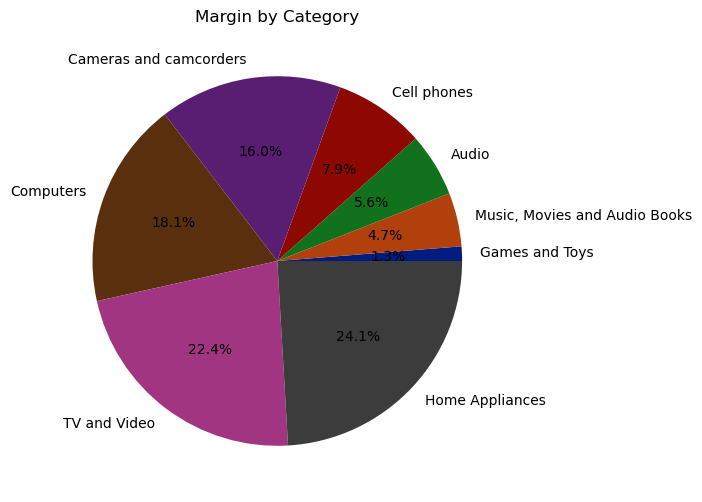

In [272]:
palette_color = sns.color_palette('dark') 
plt.figure(figsize=(8,6))
plt.pie(category_margin, labels=category_margin.index, colors=palette_color ,autopct='%1.1f%%')
plt.title('Margin by Category')
plt.show()

Which products contribute the most and least revenue?

In [273]:
revenue = data.groupby('Category')['Unit Price USD Int'].sum()

In [274]:
# contribute the most
revenue.sort_values(ascending=False).head(1)

Category
Computers    6083022.33
Name: Unit Price USD Int, dtype: float64

In [275]:
# least contribute 
revenue.sort_values(ascending=True).head(1)

Category
Games and Toys    228587.08
Name: Unit Price USD Int, dtype: float64

Here we can see that Computers contribute the most revenue, totaling 6,083,022.33, while Games and Toys contribute the least revenue, totaling 228,587.08

How do unit costs affect unit selling prices across different product categories?

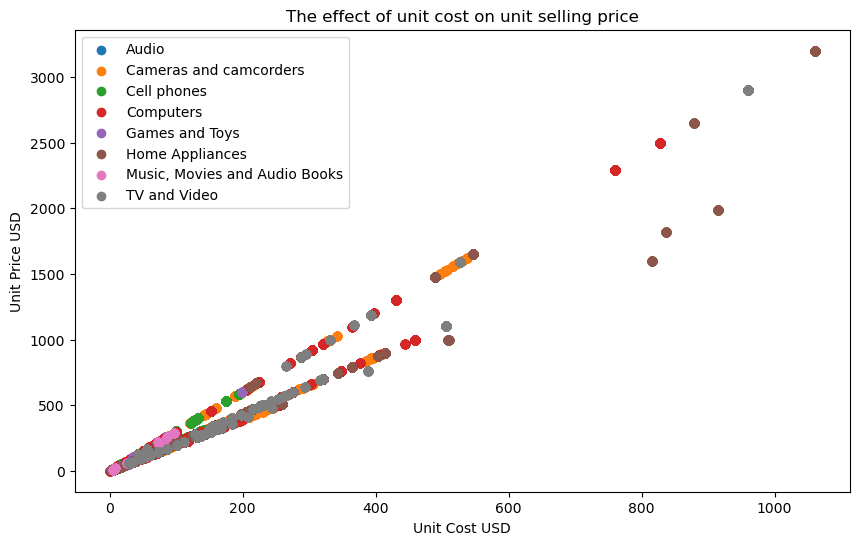

In [276]:
marginn = data['Unit Price USD Int'] - data['Unit Cost USD Int']
margin_mean = marginn.groupby(data['Category']).mean()

plt.figure(figsize=(10, 6))
for category in margin_mean.index:
    plt.scatter(data[data['Category'] == category]['Unit Cost USD Int'], data[data['Category'] == category]['Unit Price USD Int'], label=category)
plt.xlabel('Unit Cost USD')
plt.ylabel('Unit Price USD')
plt.title('The effect of unit cost on unit selling price')
plt.legend()
plt.show()

Where mostly customer come from?

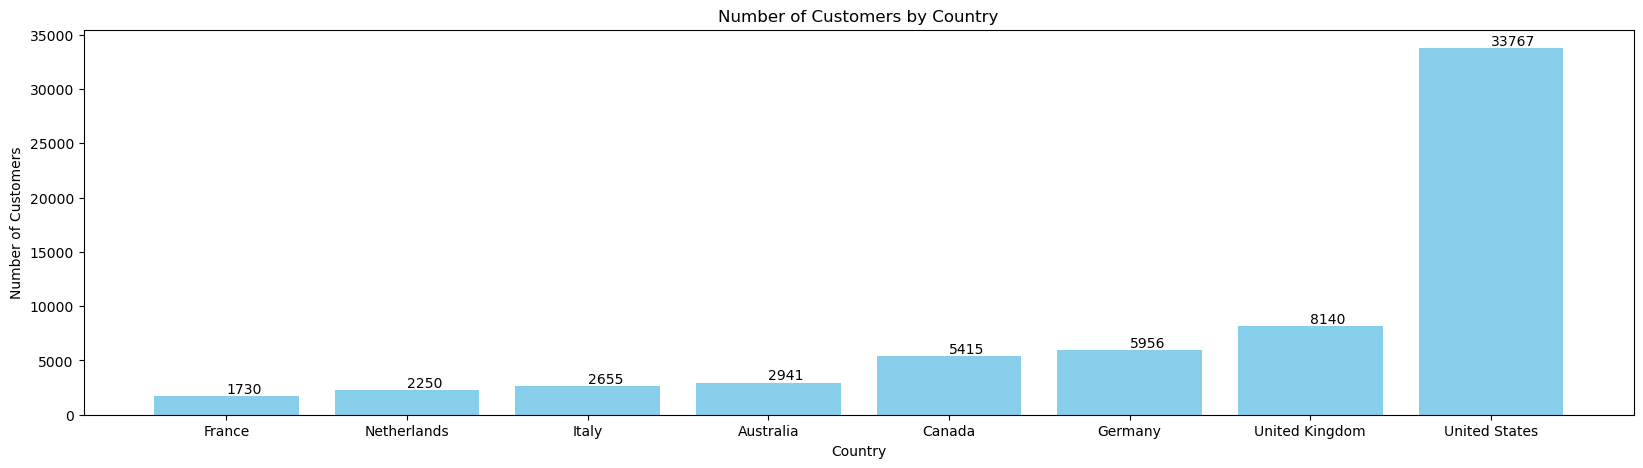

In [277]:
df = data

# Group by country and count CustomerKey
customer_count = df.groupby('Country').agg({'CustomerKey': 'count'}).sort_values(by='CustomerKey').reset_index()

# Plot the bar chart
fig, ax = plt.subplots(figsize=(20, 5))
bars = ax.bar(customer_count['Country'], customer_count['CustomerKey'], color='skyblue')

# Annotate each bar with the count value
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, int(yval), va='bottom')  # va: vertical alignment

# Add labels and title
plt.xlabel('Country')
plt.ylabel('Number of Customers')
plt.title('Number of Customers by Country')

# Show the plot
plt.show()

Most of the customers are from the United States, totaling 33,767, while the fewest customers are from France, totaling 1,730

Recommendations - To increase website traffic from other countries and implement effective marketing strategies, consider these steps:

Localized SEO: Optimize website content with relevant keywords in multiple languages to improve search engine visibility in target countries.

International PPC Campaigns: Run targeted pay-per-click advertising campaigns on search engines and social media platforms, tailored to specific regions and languages.

Multilingual Content: Translate key pages, product descriptions, and customer support into local languages to cater to diverse audiences effectively.

Regional Partnerships: Form partnerships with local influencers, bloggers, or businesses to increase brand awareness and credibility in target markets.

Localized Social Media Engagement: Actively engage with international audiences on social media platforms, using localized content and ads to drive traffic to the website.

Customer Reviews and Testimonials: Showcase customer reviews and testimonials from different countries to build trust and credibility with potential international customers.

By focusing on localization, targeted advertising, and building relationships with local influencers, the retailer can attract more international traffic to its website and effectively implement marketing strategies to increase product sales.

What are the product sales trends throughout the year?

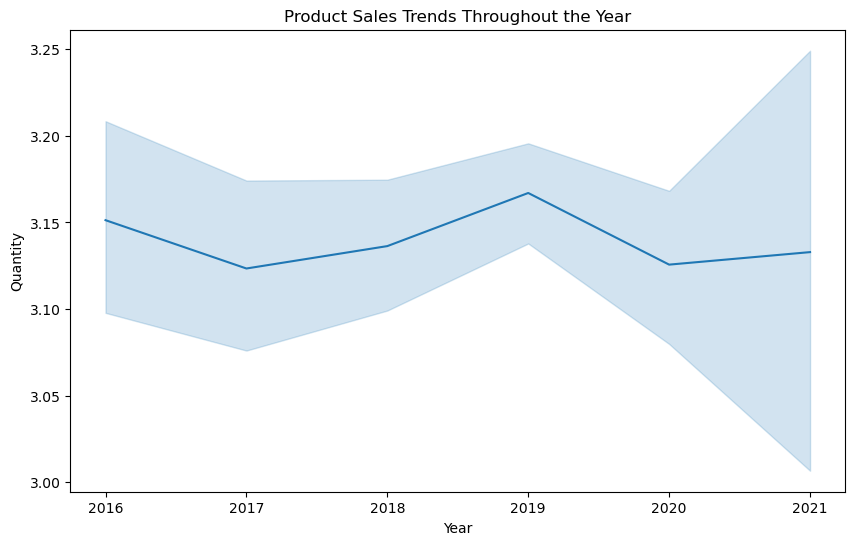

In [278]:
plt.figure(figsize=(10, 6))
sns.lineplot(x='Order Year', y='Quantity', data=data)
plt.title('Product Sales Trends Throughout the Year')
plt.xlabel('Year')
plt.ylabel('Quantity')
plt.show()

We can observe a downward trend from 2016 to 2017, followed by an increase from 2017 to 2019, and then another drop in 2020

Who is the best customer based on frequency of purchase and total amount spent?

In [279]:
customer_spend = data.groupby('CustomerKey')['Quantity'].sum().reset_index()
customer_spend.columns = ['CustomerKey', 'Total Quantity']
customer_spend.sort_values(by='Total Quantity', ascending=False).head(15)

,CustomerKey,Total Quantity
3664,723572,124
10766,1925694,123
2331,461982,107
9589,1736139,103
8588,1579183,100
11085,1972249,98
7590,1420237,95
7370,1388023,95
6723,1286602,95
8803,1610098,93


Recommendations - Based on these customer details, implementing strategies such as loyalty programs with rewards, personalized recommendations based on past purchases, targeted promotions via email and social media, VIP perks like exclusive access, and referral incentives can increase sales from frequent buyers. These strategies are designed to foster loyalty, encourage repeat purchases, and enhance overall customer engagement

Segment the data by age

In [280]:
age_groups = data.groupby('Customer Age').size().reset_index()
age_groups.columns = ['Customer Age', 'Count']
age_groups.sort_values(by='Count', ascending=False).head(3)

,Customer Age,Count
9,23.4,195
368,59.3,178
105,33.0,172


Here we can see that customers aged 59 made 178 purchases, customers aged 23.4 would make 195 purchases, and customers aged 33.0 would make 172 purchases.

Analysis for 3 age groups

In [281]:
# Filter dataframe based on customer age
young_adults = data[(data['Customer Age'] >= 18) & (data['Customer Age'] <= 25)]
adults = data[(data['Customer Age'] >= 26) & (data['Customer Age'] <= 54)]
seniors = data[data['Customer Age'] >= 55]

# Calculate the number of transactions for each age group
num_young_adults_transactions = young_adults['Order Number'].nunique()
num_adults_transactions = adults['Order Number'].nunique()
num_seniors_transactions = seniors['Order Number'].nunique()

# Calculate the average amount spent per transaction for each age group
avg_young_adults_spending = round(young_adults.groupby('Order Number')['Unit Price USD Int'].sum().mean(), 2)
avg_adults_spending = round(adults.groupby('Order Number')['Unit Price USD Int'].sum().mean(), 2)
avg_seniors_spending = round(seniors.groupby('Order Number')['Unit Price USD Int'].sum().mean(), 2)

# Calculate the percentage of young adults, adults, and seniors who bought products with a certain price
num_young_adults_high_price = young_adults[young_adults['Unit Price USD Int'] >= 100]['Order Number'].nunique()
num_adults_high_price = adults[adults['Unit Price USD Int'] >= 100]['Order Number'].nunique()
num_seniors_high_price = seniors[seniors['Unit Price USD Int'] >= 100]['Order Number'].nunique()
pct_young_adults_high_price = round(num_young_adults_high_price / num_young_adults_transactions * 100, 2)
pct_adults_high_price = round(num_adults_high_price / num_adults_transactions * 100, 2)
pct_seniors_high_price = round(num_seniors_high_price / num_seniors_transactions * 100, 2)

# Print the analysis results
print('Number of transactions:')
print('Young adults:', num_young_adults_transactions)
print('Adults:', num_adults_transactions)
print('Seniors:', num_seniors_transactions)
print('\nAverage amount spent per transaction:')
print('Young adults: $', avg_young_adults_spending)
print('Adults: $', avg_adults_spending)
print('Seniors: $', avg_seniors_spending)
print('\nPercentage of customers who bought products with price >= $100:')
print('Young adults:', pct_young_adults_high_price, '%')
print('Adults:', pct_adults_high_price, '%')
print('Seniors:', pct_seniors_high_price, '%')

Number of transactions:
Young adults: 1133
Adults: 10956
Seniors: 13508

Average amount spent per transaction:
Young adults: $ 674.81
Adults: $ 669.52
Seniors: $ 669.39

Percentage of customers who bought products with price >= $100:
Young adults: 84.2 %
Adults: 82.87 %
Seniors: 83.43 %


On average, seniors made the most transactions at 13,508, with an average transaction amount of 669.39; 83.43% of their transactions were for products priced at 100 or more
Adults made a significant number of transactions at 10,956, averaging 669.52 per transaction, with 82.87% purchasing products priced at 100 or more. Meanwhile, young adults conducted 1,133 transactions on average amounting to 674.81 per transaction, with 84.2% of their purchases meeting or exceeding the 100 price threshold.

Recommendations - 
To increase sales by age factors, consider the following strategies tailored to different age groups:

Young Adults (18-35 years):

Digital Engagement: Use social media platforms like Instagram and TikTok for product showcases and influencer collaborations.
Personalization: Offer personalized recommendations and promotions based on browsing behavior and preferences.
Mobile Optimization: Ensure the website and shopping experience are mobile-friendly and optimized for quick purchases.

Adults (36-54 years):

Content Marketing: Provide informative content such as blogs or videos addressing practical uses and benefits of products.
Email Campaigns: Use email marketing to send targeted promotions and reminders based on past purchases or interests.
Customer Service: Focus on excellent customer service and personalized support to build trust and loyalty.

Seniors (55+ years):

Ease of Use: Simplify website navigation and checkout processes to cater to older customers.
Educational Content: Provide guides and tutorials to help seniors understand product features and benefits.
Offline Channels: Utilize offline channels like direct mail or community events where seniors are likely to engage.
By understanding the preferences and behaviors of each age group and tailoring marketing strategies accordingly, the retailer can effectively increase sales across different demographics.

Recommend products based on age

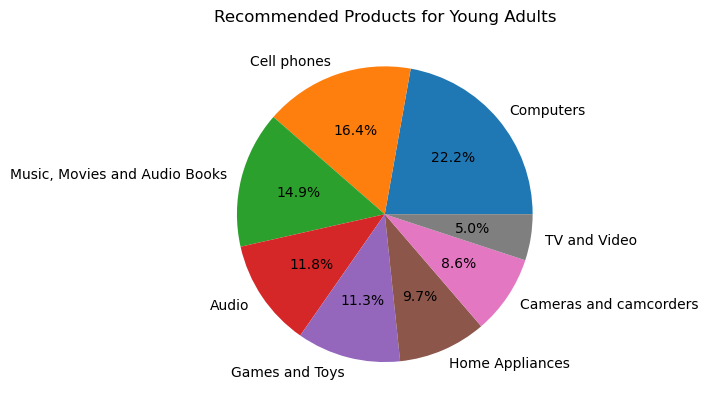

In [282]:
# young adults
recommended_products_young_adults = young_adults['Category'].value_counts()
plt.pie(recommended_products_young_adults, labels=recommended_products_young_adults.index, autopct='%1.1f%%')
plt.title('Recommended Products for Young Adults')
plt.show()

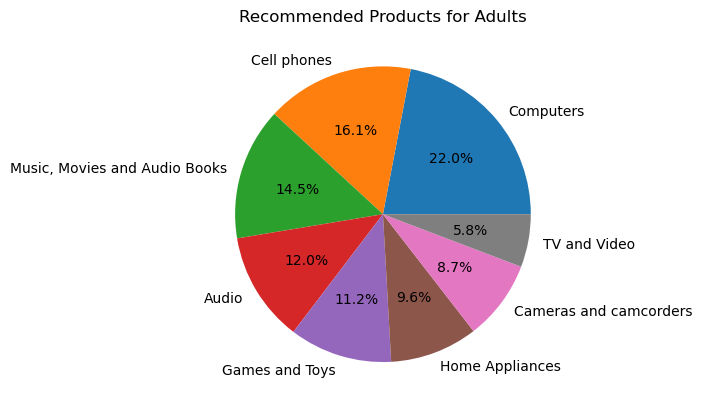

In [283]:
# adult
recommended_products_adults = adults['Category'].value_counts()
plt.pie(recommended_products_adults, labels=recommended_products_adults.index, autopct='%1.1f%%')
plt.title('Recommended Products for Adults')
plt.show()

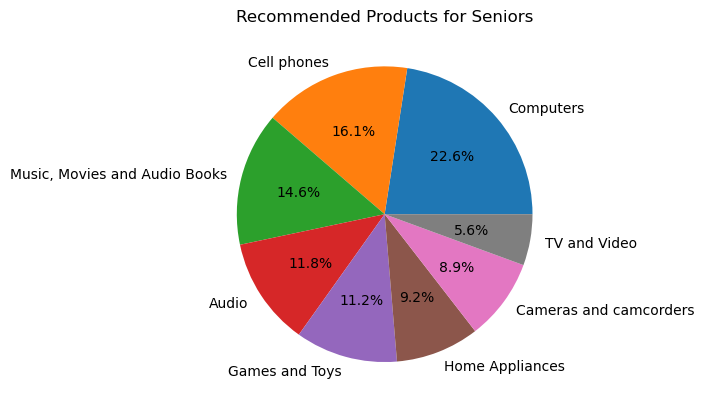

In [284]:
# seniors
recommended_products_seniors = seniors['Category'].value_counts()
plt.pie(recommended_products_seniors, labels=recommended_products_seniors.index, autopct='%1.1f%%')
plt.title('Recommended Products for Seniors')
plt.show()

Total Revenue by Customer Age Group

In [285]:
profiles = data.groupby('Customer Age').agg({'Category': 'count', 'Revenue': 'sum'}).reset_index()
profiles.columns = ['Customer Age', 'Count', 'Total Revenue']
profiles

,Customer Age,Count,Total Revenue
0,22.5,76,71009.05
1,22.6,131,148989.15
2,22.7,111,75136.86
3,22.8,75,54810.11
4,22.9,135,116643.93
...,...,...,...
666,89.1,139,137570.44
667,89.2,75,55407.55
668,89.3,99,92479.81
669,89.4,79,50927.92


Distribution of The Data

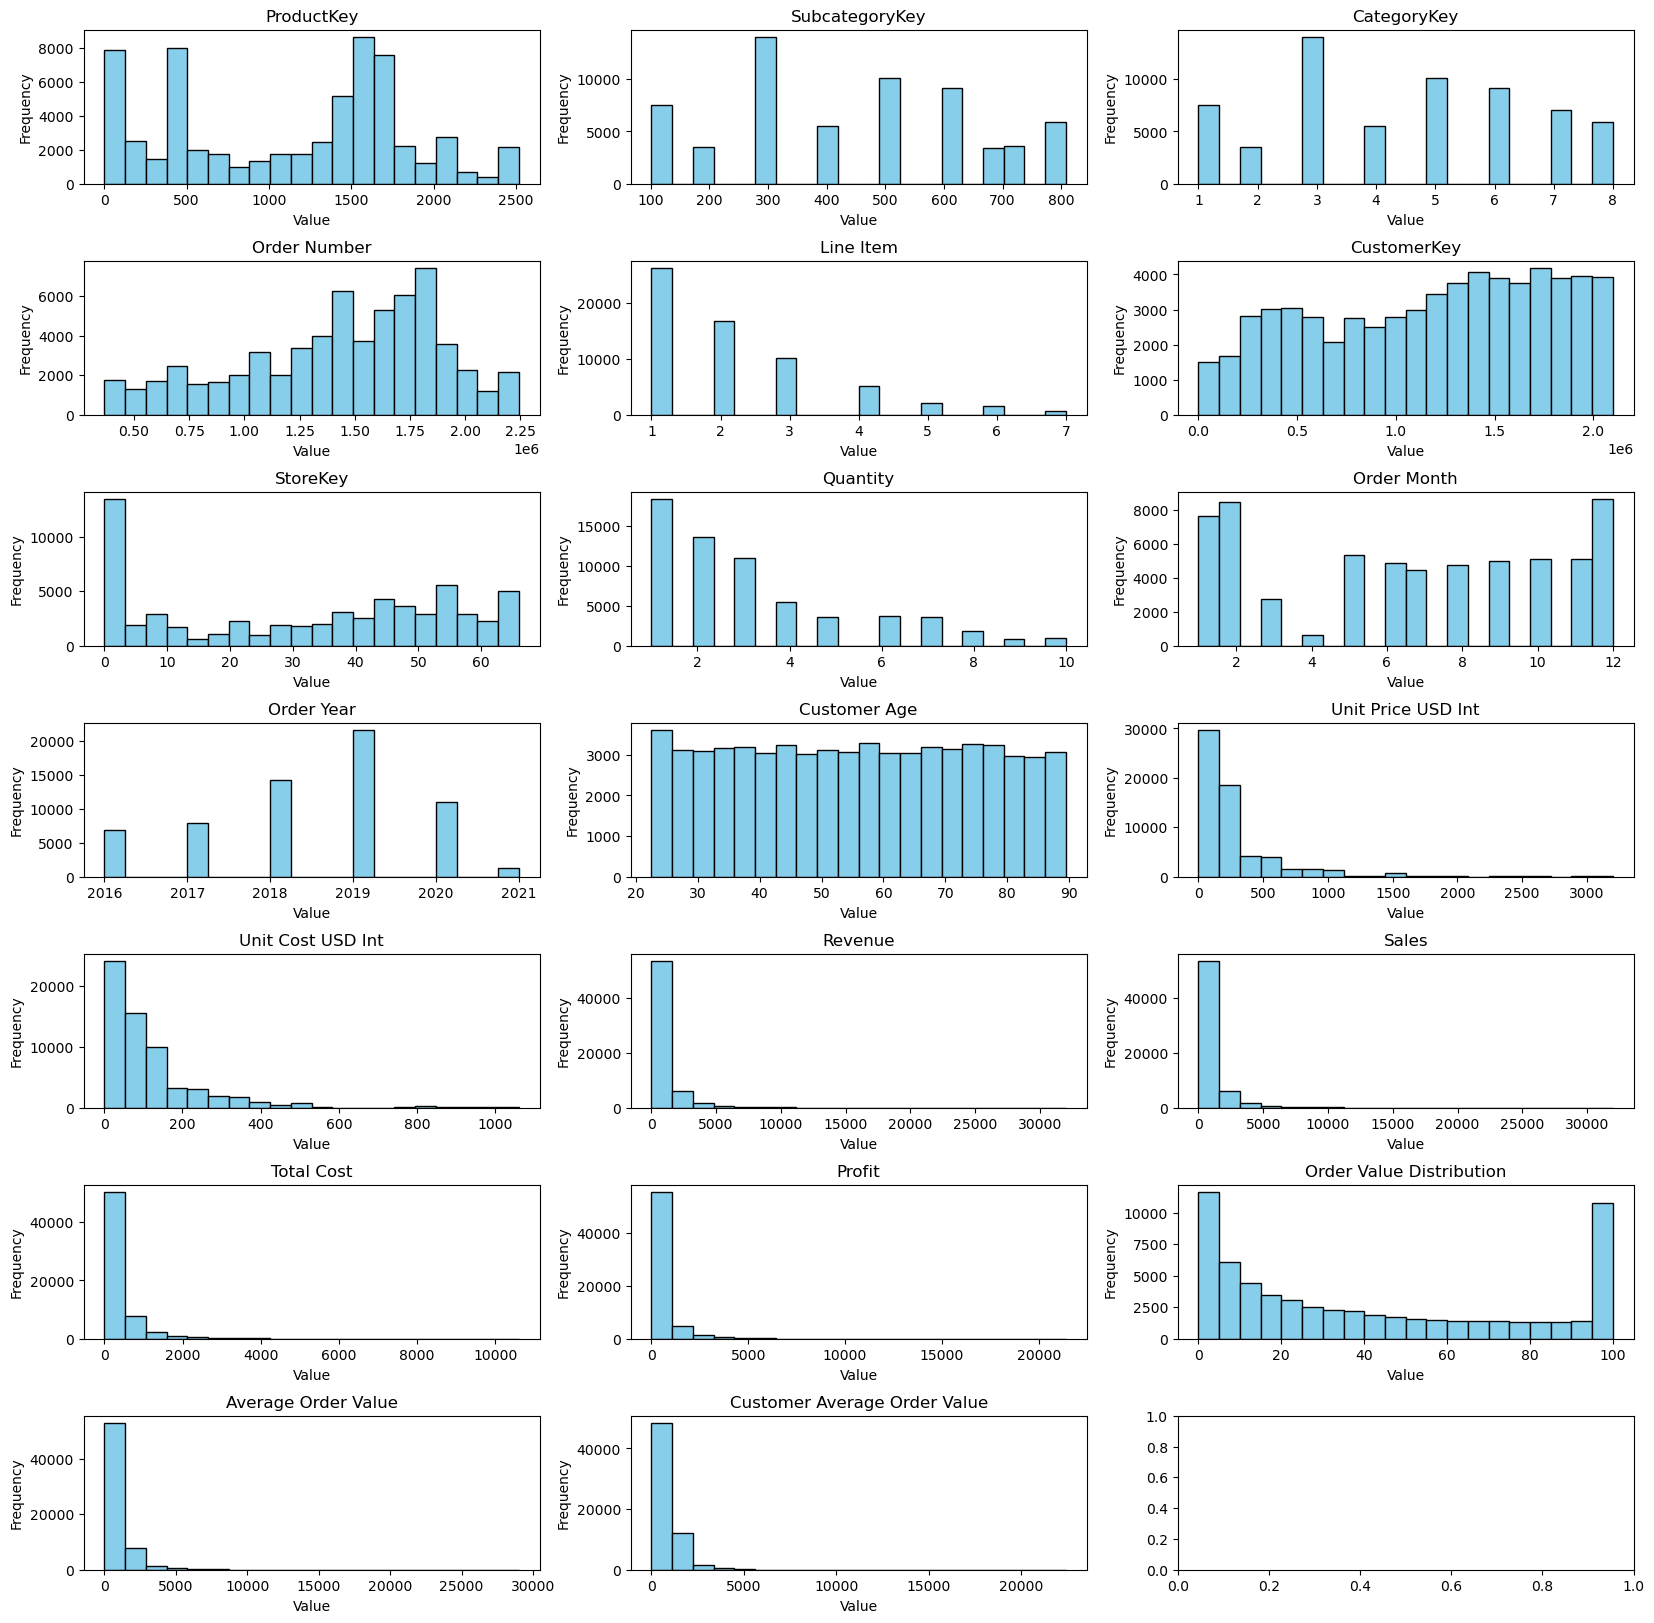

In [286]:
fig, axes = plt.subplots(nrows=7, ncols=3, figsize=(20, 20))
fig.subplots_adjust(hspace=0.5)
axes = axes.flatten()

# Distribution Plot
for i, col in enumerate(data.select_dtypes(include=['number'])):  
    ax = axes[i]
    ax.hist(data[col], bins=20, color='skyblue', edgecolor='black')
    ax.set_title(col)
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')

plt.show()